In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter
from tqdm.notebook import trange
from nltk.stem import WordNetLemmatizer

In [2]:
dt_movie = pd.read_csv("ml-latest/movies.csv")
dt_ratings = pd.read_csv("ml-latest/ratings.csv")
dt = pd.merge(dt_ratings, dt_movie)[["userId", "movieId", "title", "genres", "rating"]]

(0.0, 100.0)

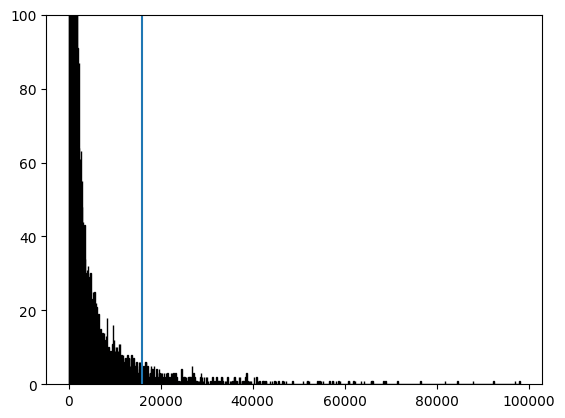

In [3]:
plt.hist(dt.groupby(['movieId']).userId.count() , color = 'blue', bins=1000, edgecolor = 'black')
plt.plot([16000 for i in range(1024)], [i for i in range(1024)])
plt.ylim([0, 100])

In [4]:
threshold = 20000
movieId = np.array(sorted(dt.movieId.unique()))[(dt.groupby(['movieId']).userId.count() > threshold).to_numpy()]

movieId = set(movieId)
right_ind = np.ones((len(dt)))
for i in trange(len(dt)):
    if dt.movieId.to_numpy()[i] not in movieId:
        right_ind[i] = -1
indexes = right_ind > 0


dt.iloc[indexes]

  0%|          | 0/27753444 [00:00<?, ?it/s]

,userId,movieId,title,genres,rating
251747,3,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.0
251748,15,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.0
251749,37,1221,"Godfather: Part II, The (1974)",Crime|Drama,3.0
251750,49,1221,"Godfather: Part II, The (1974)",Crime|Drama,2.0
251751,55,1221,"Godfather: Part II, The (1974)",Crime|Drama,3.5
...,...,...,...,...,...
17436773,283158,1573,Face/Off (1997),Action|Crime|Drama|Thriller,4.0
17436774,283171,1573,Face/Off (1997),Action|Crime|Drama|Thriller,3.0
17436775,283185,1573,Face/Off (1997),Action|Crime|Drama|Thriller,3.0
17436776,283195,1573,Face/Off (1997),Action|Crime|Drama|Thriller,2.0


In [5]:
dt = dt.iloc[indexes]

In [6]:
(dt.groupby(["userId"]).rating.count() < 3).sum()

26527

In [7]:
user_count = len(dt.groupby(["userId"]))
index = np.arange(1, user_count + 1)
user_for_skip = index[(dt.groupby(["userId"]).rating.count() < 3).values]
user_for_skip = set(user_for_skip)
right_ind = np.ones((len(dt)))
for i in trange(len(dt)):
    if dt.userId.to_numpy()[i] in user_for_skip:
        right_ind[i] = -1
indexes = right_ind > 0


dt.iloc[indexes]

  0%|          | 0/8202246 [00:00<?, ?it/s]

,userId,movieId,title,genres,rating
251747,3,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.0
251748,15,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.0
251749,37,1221,"Godfather: Part II, The (1974)",Crime|Drama,3.0
251750,49,1221,"Godfather: Part II, The (1974)",Crime|Drama,2.0
251752,56,1221,"Godfather: Part II, The (1974)",Crime|Drama,3.0
...,...,...,...,...,...
17436773,283158,1573,Face/Off (1997),Action|Crime|Drama|Thriller,4.0
17436774,283171,1573,Face/Off (1997),Action|Crime|Drama|Thriller,3.0
17436775,283185,1573,Face/Off (1997),Action|Crime|Drama|Thriller,3.0
17436776,283195,1573,Face/Off (1997),Action|Crime|Drama|Thriller,2.0


In [8]:
dt = dt.iloc[indexes]

In [9]:
lemmatizer = WordNetLemmatizer()

def tokenize(text):
    punctuation_marks = ",.?!:;\'\(\)\{\}\|"
    stop_words = ["a", "the"]
    text = text.lower()
    for symbol in text:
        if symbol in punctuation_marks:
            text = text.replace(symbol, " ")
    if text == " no genres listed ":
        return [text[1:-1]]
    text = text.replace("\n", "")
    if text[-1] == " ":
        text = text[:-1]
    tokens = []
    for token in text.split(" "):
        if token != "" and token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return tokens

In [10]:
def show_graph(vocab, sizes):
    show_ = 20
    fig, ax = plt.subplots(3, 1, figsize=(15, 9))

    plt.subplot(312)
    vocab = {k: v for k, v in sorted(vocab.items(), key=lambda item: item[1])}
    plt.title('least popular words')
    plt.bar(list(vocab.keys())[:show_], list(vocab.values())[:show_])

    plt.subplot(311)
    vocab = {k: v for k, v in sorted(vocab.items(), key=lambda item: item[1], reverse=True)}
    plt.title('most popular words')
    plt.bar(list(vocab.keys())[:show_], list(vocab.values())[:show_])

    plt.subplot(313)
    plt.title('sequence sizes')
    plt.bar(list(sizes.keys()), list(sizes.values()))

    fig.tight_layout()
    plt.show()

In [11]:
def update_vocab(dt_merge, vocab, sizes, max_len, genres=False, print_long_tokens=False):
    for_skip = []
    dt = dt_merge.genres if genres else dt_merge.title
    for i in trange(len(dt)):
        title = dt.to_numpy()[i]
        title_vocab = Counter(tokenize(title))
        if(len(title_vocab)) > max_len:
            if print_long_tokens:
                print(dt_merge.title.to_numpy()[i])
            for_skip.append(dt_merge.movieId.to_numpy()[i])
            continue
        sizes[len(title_vocab)] += 1
        vocab.update(title_vocab)
    return for_skip

In [12]:
vocab_title = Counter()
sizes_title = Counter()

vocab_genres = Counter()
sizes_genres = Counter()
movie_for_skip = []
movie_for_skip.extend(update_vocab(dt, vocab_title, sizes_title, 11, False))
movie_for_skip.extend(update_vocab(dt, vocab_genres, sizes_genres, 8, True))

  0%|          | 0/7441183 [00:00<?, ?it/s]

  0%|          | 0/7441183 [00:00<?, ?it/s]

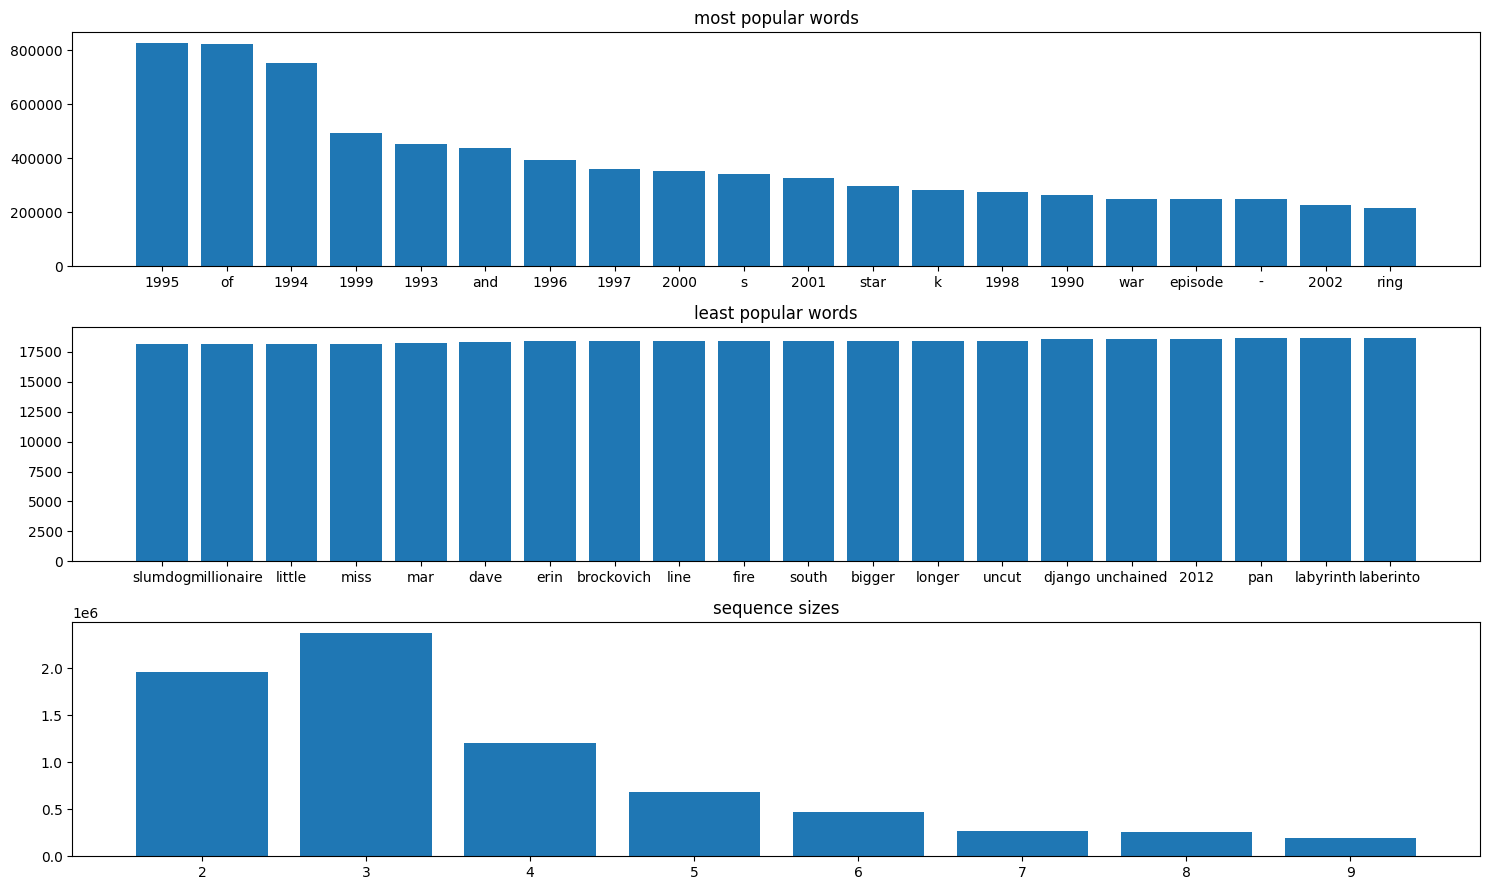

In [13]:
show_graph(vocab_title, sizes_title)

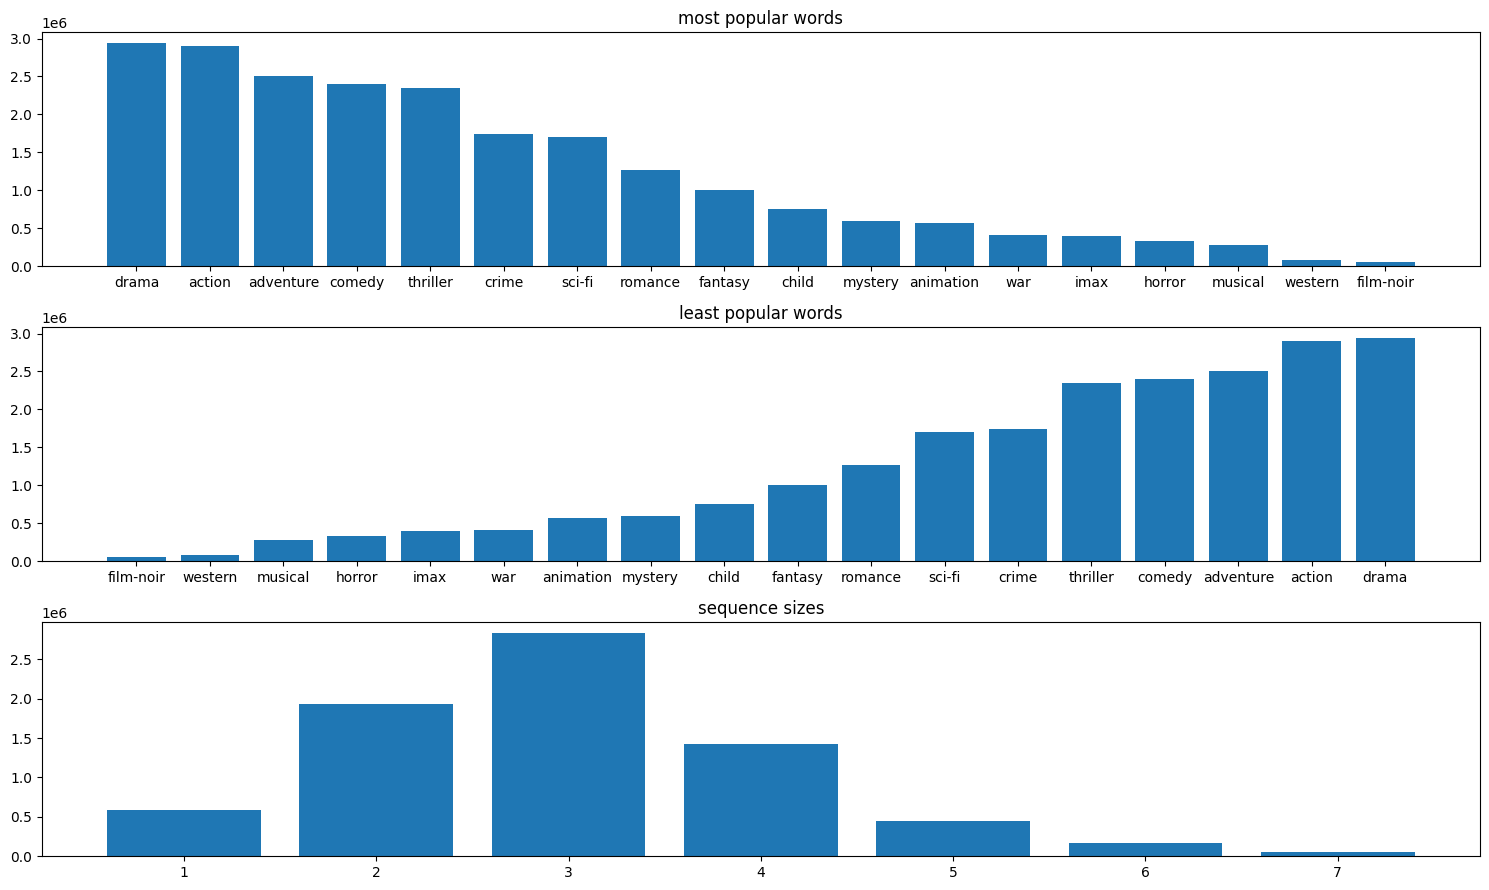

In [14]:
show_graph(vocab_genres, sizes_genres)

In [15]:
vocab_title = Counter()
sizes_title = Counter()

vocab_genres = Counter()
sizes_genres = Counter()
movie_for_skip = []
movie_for_skip.extend(update_vocab(dt, vocab_title, sizes_title, 10, False))
movie_for_skip.extend(update_vocab(dt, vocab_genres, sizes_genres, 7, True))

  0%|          | 0/7441183 [00:00<?, ?it/s]

  0%|          | 0/7441183 [00:00<?, ?it/s]

In [16]:
tok_to_ind = {
    "[PAD]": 0,
    "[UNK]": 1,
    "no genres listed": 2
}
ind_to_tok = {
    0: "[PAD]",
    1: "[UNK]",
    2: "no genres listed"
}

In [17]:
min_frequency = 3
last_free_index = len(tok_to_ind)
for token in vocab_title.keys():
    if vocab_title[token] >= min_frequency and token not in tok_to_ind:
        tok_to_ind[token] = last_free_index
        ind_to_tok[last_free_index] = token
        last_free_index += 1

for token in vocab_genres.keys():
    if vocab_genres[token] >= min_frequency and token not in tok_to_ind:
        tok_to_ind[token] = last_free_index
        ind_to_tok[last_free_index] = token
        last_free_index += 1

In [18]:
movie_for_skip = set(movie_for_skip)
right_ind = np.ones((len(dt)))
for i in trange(len(dt)):
    if dt.movieId.to_numpy()[i] in movie_for_skip:
        right_ind[i] = -1
indexes = right_ind > 0
dt.iloc[indexes]

  0%|          | 0/7441183 [00:00<?, ?it/s]

,userId,movieId,title,genres,rating
251747,3,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.0
251748,15,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.0
251749,37,1221,"Godfather: Part II, The (1974)",Crime|Drama,3.0
251750,49,1221,"Godfather: Part II, The (1974)",Crime|Drama,2.0
251752,56,1221,"Godfather: Part II, The (1974)",Crime|Drama,3.0
...,...,...,...,...,...
17436773,283158,1573,Face/Off (1997),Action|Crime|Drama|Thriller,4.0
17436774,283171,1573,Face/Off (1997),Action|Crime|Drama|Thriller,3.0
17436775,283185,1573,Face/Off (1997),Action|Crime|Drama|Thriller,3.0
17436776,283195,1573,Face/Off (1997),Action|Crime|Drama|Thriller,2.0


In [19]:
dt = dt.iloc[indexes]

In [20]:
dt.to_csv("data.csv")

In [21]:
import pickle 

with open('tok_to_ind.pkl', 'wb') as f:
    pickle.dump(tok_to_ind, f)